<a href="https://colab.research.google.com/github/Only-Mike/DeepLearning-and-AI/blob/main/Group%20Assigment2/GroupAssignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [6]:
stock_data_train = pd.read_csv('/content/train.csv')
stock_data_test = pd.read_csv('/content/test.csv')

stock_data = pd.concat([stock_data_train, stock_data_test])

In [9]:
scaler = MinMaxScaler() 
data_scaled = scaler.fit_transform(stock_data[['store', 'product', 'number_sold']])
data_s = pd.DataFrame(data_scaled, columns=['store', 'product', 'number_sold'])
stock_data = data_s[['number_sold']].to_numpy()

In [10]:
# Split the data into sequences for RNN input
sequence_length = 20
sequence_data = []
sequence_labels = []
for i in range(len(stock_data) - sequence_length):
    sequence_data.append(stock_data[i:i+sequence_length])
    sequence_labels.append(stock_data[i+sequence_length])
sequence_data = np.array(sequence_data)
sequence_labels = np.array(sequence_labels)

train_data = sequence_data[:2000]
train_labels = sequence_labels[:2000]
test_data = sequence_data[2000:]
test_labels = sequence_labels[2000:]

In [11]:
# Split the data into training and testing sets
train_data = TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
test_data = TensorDataset(torch.from_numpy(test_data), torch.from_numpy(test_labels))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [12]:
# Initialize the LSTM model
input_size = 1
hidden_size = 6
output_size = 1

# 1. Creating an LSTM model
lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
fc = nn.Linear(hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.01)

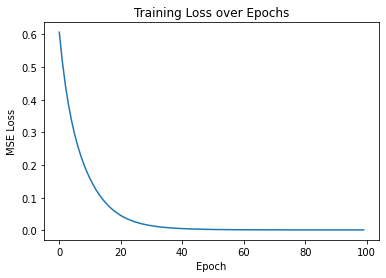

Test MSE: 0.03665491626680788


In [13]:
# Train the lstm model
num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = 0

    for i, (data, label) in enumerate(train_loader):
        optimizer.zero_grad()

        # Run the forward pass
        hidden = (torch.zeros(1, data.size(0), hidden_size),
                  torch.zeros(1, data.size(0), hidden_size))
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[0][-1])

        # 2. Network Evaluation
        loss = criterion(output, label.float())

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

# Evaluate the lstm model
mse = 0

with torch.no_grad():
    for data, label in test_loader:
        hidden = (torch.zeros(1, data.size(0), hidden_size),
                  torch.zeros(1, data.size(0), hidden_size))
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[0][-1])

        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))